In [2]:
using LinearAlgebra, DataFrames, Plots, Polynomials, Statistics, CSV

#### Zadanie 1 (2 pkt)
Ustal losowe (referencyjne) x rozmiaru 1000 oraz losowe A rozmiaru 1000x1000, policz b=A*x.
Nastepnie rozwiąż równanie Ax=b trzema metodami:
- inv()
- \
- factorize()

Porównaj jakość wyniku (zmierzoną jako długość różnicy wektorów wyniku oraz referencyjnego x) oraz czas wykonania (@time). UWAGA: pierwsze wykonanie funkcji w Julii zawiera czas kompilacji tej funkcji, dlatego czas mierzymy  od drugiego wywołania !

In [3]:
result = DataFrame(Method=String[], Error=Float64[], Time=Float64[])

for i in 1:10

    # Generowanie losowych danych
    x = rand(1000)
    A = rand(1000, 1000)
    b = A * x

    inv_diff = x - inv(A)*b
    inv_res = sqrt(dot(inv_diff,inv_diff))
    inv_time = @elapsed inv(A)*b

    norm_diff = x - A\b
    norm_res = sqrt(dot(norm_diff, norm_diff))
    norm_time = @elapsed A\b

    fact_diff = x - factorize(A)\b
    fact_res = sqrt(dot(fact_diff, fact_diff))
    fact_time = @elapsed factorize(A)\b

    if i == 1
        continue
    end

    push!(result, ("inv", inv_res, inv_time))
    push!(result, ("\\", norm_res, norm_time))
    push!(result, ("factorize", fact_res, fact_time))
end

grouped_result = combine(groupby(result, :Method), :Error => mean, :Time => mean)

Row,Method,Error_mean,Time_mean
,String,Float64,Float64
1,inv,2.83488e-10,0.0446275
2,\\,1.49291e-10,0.0158
3,factorize,1.49291e-10,0.0184908


#### Zadanie 2 (2 pkt)
Policz współczynniki wielomianu aproksymującego dowolne dane z poprzednich laboratoriów tworząc wprost układ równań i rozwiązujac go (metoda z użyciem faktoryzacji QR zaprezentowana na tym laboratorium).
Porównaj wyniki z tymi otrzymanymi poprzednio.

Metoda z użyciem faktoryzacji QR została porównania z metodą z laboratorium 5 na danych otrzymanych z pomiaru czasu mnożenia macierzy różnymi metodami w zależności od rozmiarów macierzy

In [4]:
data = CSV.read("stats.csv", DataFrame)

Row,Size,Type,Time_mean,Time_std
,Int64,String7,Float64,Float64
1,100,naive,0.00266655,1.41139e-5
2,100,better,0.000624856,1.63916e-5
3,100,blas,0.000254627,2.60383e-5
4,200,naive,0.0223204,0.000266634
5,200,better,0.00464153,0.000145501
6,200,blas,0.00184792,1.00507e-5
7,300,naive,0.0775461,0.00293885
8,300,better,0.0158386,0.00022063
9,300,blas,0.00637348,9.21955e-5


##### Faktoryzacja na pomiarach metody naiwnej

In [5]:
x_data_naive = data[data.Type .== "naive", :Size]
y_data_naive = data[data.Type .== "naive", :Time_mean]

# Macierz A dla faktoryzacji QR
A=zeros(10,4) 
A[:,1]=x_data_naive.^3
A[:,2]=x_data_naive.^2
A[:,3]=x_data_naive
A[:,4]=ones(10)

# Faktoryzacja QR
Q, R = factorize(A)

QRPivoted{Float64, Matrix{Float64}, Vector{Float64}, Vector{Int64}}
Q factor:
10×10 LinearAlgebra.QRPackedQ{Float64, Matrix{Float64}, Vector{Float64}}:
 -0.000710955  -0.0339428  -0.378124   …  -0.0960535  -0.207478   -0.282764
 -0.00568764   -0.118713   -0.518293      -0.0634765   0.220747    0.678134
 -0.0191958    -0.228722   -0.48057        0.497687    0.316026   -0.144889
 -0.0455012    -0.338383   -0.325016      -0.168339   -0.252272   -0.533898
 -0.0888694    -0.422107   -0.111694      -0.128003   -0.0471947   0.0717579
 -0.153566     -0.454308    0.0993344  …  -0.218805   -0.0870957   0.158386
 -0.243858     -0.409397    0.248007      -0.273819   -0.128876    0.1746
 -0.364009     -0.261787    0.274262       0.723252   -0.183053    0.0511814
 -0.518287      0.0141099   0.118037      -0.211292    0.739858   -0.281087
 -0.710955      0.443882   -0.280731      -0.0611514  -0.370663    0.108578
R factor:
4×4 Matrix{Float64}:
 -1.40656e9  -1.56997e6  -1801.06   -2.15064
  0.0       

Wielomian aproksymujący:0.0122818 - 0.000146845*x + 4.38537e-7*x^2 + 2.51626e-9*x^3
Wielomian uzyskany poprzednio: 

0.0122818 - 0.000146845*x + 4.38537e-7*x^2 + 2.51626e-9*x^3


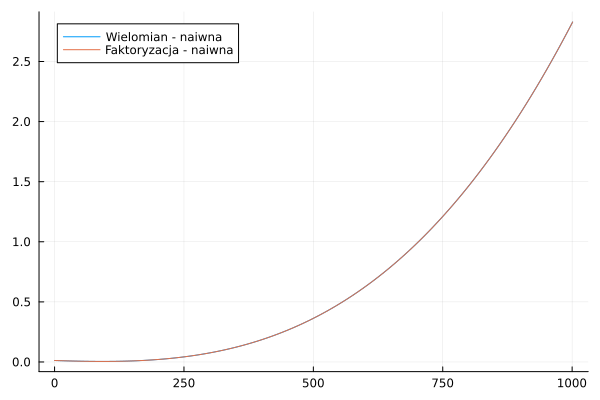

In [6]:
# Współczynniki aproksymacji
coefficients = R\((Transpose(Q)*y_data_naive)[1:4])

# # Tworzenie wielomianu aproksymującego
poly_approx = Polynomial(reverse(coefficients))

# # Wyświetlenie wyników aproksymacji
println("Wielomian aproksymujący:", poly_approx)
fit1 = fit(data[data.Type .== "naive", :Size], data[data.Type .== "naive", :Time_mean], 3)
println("Wielomian uzyskany poprzednio: ", fit1)

xs = 0:1:1001
p1 = plot(fit1, extrema(xs)..., label="Wielomian - naiwna")
plot!(poly_approx, extrema(xs)..., label="Faktoryzacja - naiwna")

##### Pozostałe dane

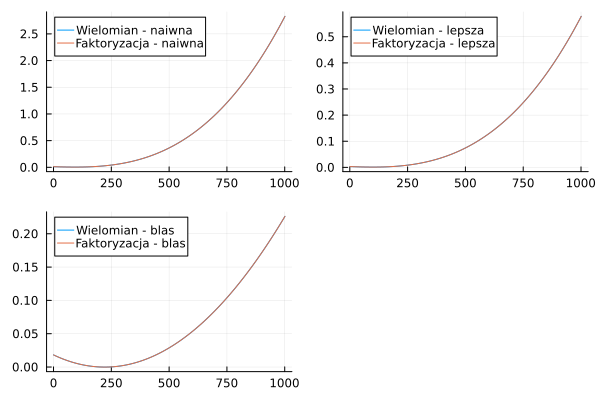

In [7]:
x_data_better = data[data.Type .== "better", :Size]
y_data_better = data[data.Type .== "better", :Time_mean]

A=zeros(10,4) 
A[:,1]=x_data_better.^3
A[:,2]=x_data_better.^2
A[:,3]=x_data_better
A[:,4]=ones(10)

Q, R = factorize(A)
coefficients = R\((Transpose(Q)*y_data_better)[1:4])

poly_approx = Polynomial(reverse(coefficients))
fit2 = fit(data[data.Type .== "better", :Size], data[data.Type .== "better", :Time_mean], 3)

p2 = plot(fit2, extrema(xs)..., label="Wielomian - lepsza")
plot!(poly_approx, extrema(xs)..., label="Faktoryzacja - lepsza")

x_data_blas = data[data.Type .== "blas", :Size]
y_data_blas = data[data.Type .== "blas", :Time_mean]

A=zeros(10,3) 
A[:,1]=x_data_blas.^2
A[:,2]=x_data_blas
A[:,3]=ones(10)

Q, R = factorize(A)
coefficients = R\((Transpose(Q)*y_data_blas)[1:3])

poly_approx = Polynomial(reverse(coefficients))
fit3 = fit(data[data.Type .== "blas", :Size], data[data.Type .== "blas", :Time_mean], 2)

p3 = plot(fit3, extrema(xs)..., label="Wielomian - blas")
plot!(poly_approx, extrema(xs)..., label="Faktoryzacja - blas")

plot(p1, p2, p3, layout=3)

##### Wnioski
Jak widać na powyższym wykresie, metoda z użyciem faktoryzacji QR okazała się równie skuteczna w wyznaczeniu wielomianu aproksymującego, co metoda z laboratorium 5 funkcją fit.

#### Zadanie 3 (4 pkt)

Znajdź i zaprezentuj działanie innego zastosowania wybranej faktoryzacji. Przykładowe (ale nie jedyne!) tematy:

-    tworzenie pseudoinversji macierzy (http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-macausland-pseudo-inverse-present.pdf).

-   uzycie faktoryzacji QR do znajdowania wartości własnych (https://en.wikipedia.org/wiki/QR_algorithm)

-  zastosowanie faktoryzacji SVD - np. zastosowania w uczeniu maszynowym 

##### Metoda pseudoinwersji macierzy

In [8]:
function print_matrix(matrix)
    for i in 1:size(matrix, 1)
        for j in 1:size(matrix, 2)
            print(matrix[i, j], " ")
        end
        println()
    end
end

# przykładowa macierz nieodwracalna
A = [1 2 3; 4 5 6; 7 8 9]
print_matrix(A)
println("wyznacznik: ", 0)

1 2 3 
4 5 6 
7 8 9 
wyznacznik: 0


Dla danej macierzy A, jej pseudoinwersja (oznaczana jako A⁺) spełnia następujące warunki:

- Jeżeli macierz A jest odwracalna, to pseudoinwersja A⁺ jest równa odwrotności A, czyli A⁺ = A⁻¹.
- Jeżeli macierz A nie jest odwracalna, pseudoinwersja A⁺ pozwala nam znaleźć rozwiązanie x równania Ax = b, które minimalizuje normę euklidesową ||Ax - b||. Oznacza to, że A⁺ jest "najlepszym" przybliżeniem odwrotności A w sensie minimalizacji błędu.

Faktoryzacja QR rozkłada macierz A na iloczyn macierzy ortogonalnej Q i macierzy trójkątnej górnej R. 

Pseudoinwersja macierzy A jest obliczana w następujący sposób:

- Obliczenie faktoryzacji QR macierzy A: A = QR.
- Obliczenie odwrotność macierzy R: R⁻¹.
- Obliczenie pseudoinwersji macierzy A: A⁺ = R⁻¹ * Q'.

Pseudoinwersja macierzy A jest wynikiem mnożenia macierzy odwrotnej R⁻¹ przez transpozycję macierzy Q. Ta procedura wykorzystuje własności faktoryzacji QR i pozwala na znalezienie pseudoinwersji macierzy A.

W praktyce, używanie pseudoinwersji macierzy jest przydatne w przypadkach, gdy rozwiązanie liniowego równania Ax = b jest niemożliwe lub numerycznie niestabilne. Pseudoinwersja macierzy pozwala na znalezienie optymalnego przybliżenia rozwiązania i może być stosowana w wielu problemach, takich jak dopasowywanie krzywych, regresja nieliniowa, rozwiązywanie układów równań nadokreślonych i wiele innych.

In [11]:
function compute_pseudoinverse(A)
    Q, R = qr(A)
    R_inv = inv(R)
    pseudoinverse = R_inv * Q'
    return pseudoinverse
end

# Obliczenie pseudoinversji macierzy
pseudoinverse = compute_pseudoinverse(A)

println("Pseudoinwersja macierzy A:")
print_matrix(pseudoinverse)

Pseudoinwersja macierzy A:
-4.59646712201924e14 9.19293424403848e14 -4.596467122019239e14 
9.192934244038462e14 -1.838586848807696e15 9.19293424403848e14 
-4.5964671220192275e14 9.192934244038481e14 -4.5964671220192425e14 


W tym kodzie funkcja compute_pseudoinverse przyjmuje macierz A i oblicza jej pseudoinwersję. 
Wykorzystujemy fakt, że faktoryzacja QR rozkłada macierz A na iloczyn macierzy ortogonalnej Q i macierzy trójkątnej górnej R. Następnie obliczana jest odwrotność macierzy R (R_inv) i pseudoinwersja jest uzyskiwana poprzez pomnożenie R_inv przez transpozycję macierzy Q.